<a href="https://colab.research.google.com/github/luishpinto/turbofan-engine-data-set/blob/master/rul_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os.path

if not os.path.exists('test_FD001.txt'):
  !wget -O 'test_FD001.txt' \
  'https://github.com/luishpinto/turbofan-engine-data-set/blob/master/data-set/test_FD001.txt?raw=true'
  
if not os.path.exists('train_FD001.txt'):
  !wget -O 'train_FD001.txt' \
  'https://github.com/luishpinto/turbofan-engine-data-set/blob/master/data-set/train_FD001.txt?raw=true'
  
if not os.path.exists('RUL_FD001.txt'):
  !wget -O 'RUL_FD001.txt' \
  'https://github.com/luishpinto/turbofan-engine-data-set/blob/master/data-set/RUL_FD001.txt'

In [0]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.size'] = 12

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from keras.models import *
from keras.layers import *
from keras.utils import to_categorical  

Using TensorFlow backend.


In [0]:
names = np.array(['unit','time','lpcoutlettemp','hpcoutlettemp',\
                  'lptoutlettemp','totalhpcoutletpres',\
                  'physfanspeed','physcorespeed','statichpcoutletpres',\
                  'fuelflowratio','corrfanspeed','corrcorespeed',\
                  'bypassratio','bleedenthalpy','hptcoolantbleed',\
                  'lptcoolantbleed'])

sensors = np.array(['lpcoutlettemp','hpcoutlettemp',\
                    'lptoutlettemp','totalhpcoutletpres',\
                    'physfanspeed','physcorespeed','statichpcoutletpres',\
                    'fuelflowratio','corrfanspeed','corrcorespeed',\
                    'bypassratio','bleedenthalpy','hptcoolantbleed',\
                    'lptcoolantbleed'])

labels = np.array(['Temperature at LPC outlet (°R)',
                   'Temperature at HPC outlet (°R)',
                   'Temperature at LPT outlet (°R)',
                   'Total pressure at HPC outlet (psia)',
                   'Physical fan speed (rpm)',
                   'Physical core speed (rpm)',
                   'Static pressure at HPC outlet (psia)',
                   'Fuel flow ratio (pps/psi)',
                   'Corrected fan speed (rpm)',
                   'Corrected core speed (rpm)',
                   'Bypass ratio',
                   'Bleed enthalpy',
                   'HPT coolant bleed (lbm/s)',
                   'LPT coolant bleed (lbm/s)'])

columns = np.array([0,1,6,7,8,11,12,13,15,16,17,18,19,21,24,25])

In [0]:
def normalization(df):
  dfnorm = df[['ttf']]
  dfnorm = pd.concat([dfnorm,((df[sensors] - df.mean()[sensors])\
                     /df.std()[sensors]).reindex(dfnorm.index)],\
                     axis = 1).dropna()
  dfnorm = pd.concat([dfnorm,df[['status']].reindex(dfnorm.index)],\
                     axis = 1).dropna()
  return dfnorm

In [0]:
def plotConfusionMatrix(dtrue,dpred,classes,title = None,\
                        cmap = plt.cm.Blues):
  
  #if not title:
  #  title = 'Confusion Matrix'
  
  cm = confusion_matrix(dtrue,dpred)
  cm = cm.astype('float') / cm.sum(axis = 1)[:,np.newaxis]
  
  fig,ax = plt.subplots(figsize = (np.shape(classes)[0]*1.25,\
                                   np.shape(classes)[0]*1.25))
  im = ax.imshow(cm,interpolation = 'nearest',cmap = cmap)
  #ax.figure.colorbar(im,ax = ax)
  
  ax.set(xticks = np.arange(cm.shape[1]),
         yticks = np.arange(cm.shape[0]),
         xticklabels = classes,
         yticklabels = classes,
         #title = title,
         ylabel = 'True',
         xlabel = 'Predicted')
  
  plt.setp(ax.get_xticklabels(),rotation = 90,ha = 'right',
           rotation_mode = 'anchor')

  fmt = '.2f'

  thresh = cm.max() / 2.0
  
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      ax.text(j,i,format(cm[i,j],fmt),ha = 'center',va = 'center',
              color = 'white' if cm[i,j] > thresh else 'black')
  fig.tight_layout()
  return ax

In [0]:
df = pd.read_csv('train_FD001.txt',sep = ' ',\
                 names = names,usecols = columns)
rul = pd.read_csv('RUL_FD001.txt',names = ['RUL'])

In [0]:
ttf = np.zeros(df.shape[0])

for i in range(int(np.max(df['unit']))):
  jindex = df.loc[df.unit == (i + 1)].index
  for j in jindex:
    ttf[j] = df['time'][jindex[-1]] - df['time'][j]
    
ttf = pd.Series(ttf)

df['ttf'] = ttf

In [0]:
th = [0.0,25.0,125.0,200.0]

status = np.zeros(df.shape[0])

for i in range(status.size):
  if ((df['ttf'][i] >= th[0]) & (df['ttf'][i] < th[1])):
    status[i] = 3.0
  elif ((df['ttf'][i] >= th[1]) & (df['ttf'][i] < th[2])):
    status[i] = 2.0
  elif ((df['ttf'][i] >= th[2]) & (df['ttf'][i] < th[3])):
    status[i] = 1.0
  else:
    status[i] = 0.0
    
status = pd.Series(status)

df['status'] = status

del status

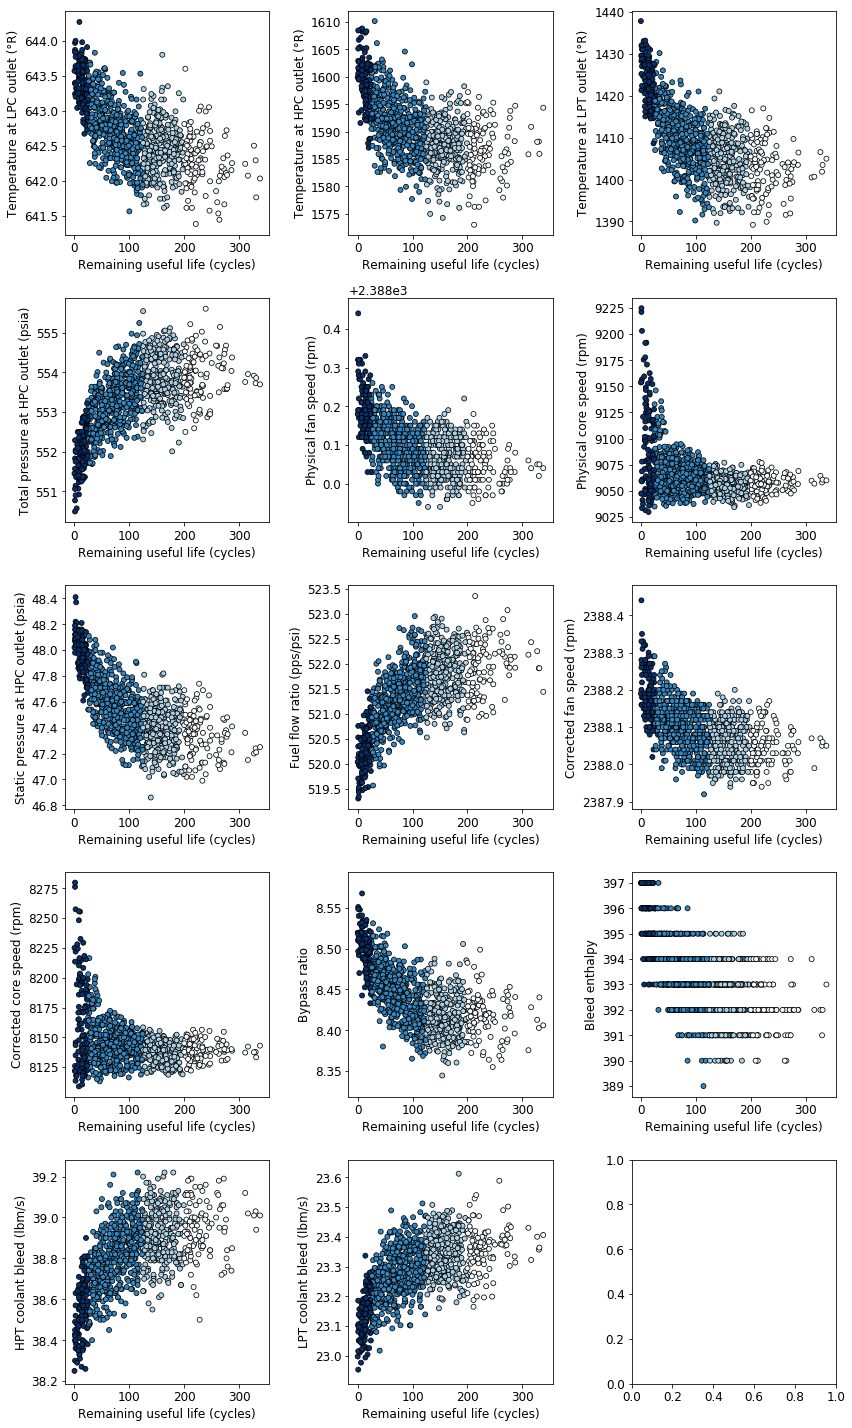

In [10]:
dfsample = df.sample(1000)

plt.subplots(5,3,figsize = (12.0,20.0),sharex = True)
j = 1
for i in sensors:
  plt.subplot(5,3,j)
  plt.scatter(dfsample.ttf,dfsample[i],c = dfsample.status,\
              cmap = plt.cm.Blues,s = 25,edgecolor = 'black',\
              linewidth = 0.75)
  plt.xlabel(r'Remaining useful life (cycles)')
  plt.ylabel(labels[j - 1])
  j += 1

plt.tight_layout()
plt.savefig('fig-3.ps',dpi = 300,format = 'ps')
plt.show()

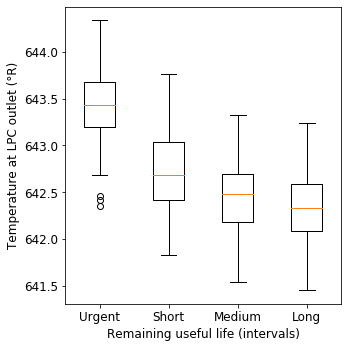

In [11]:
dfsample = df

bp = np.zeros((200,4))

for i in [0,1,2,3]:
  bp[:,i] = dfsample.loc[dfsample.status == i]['lpcoutlettemp'].sample(200)

plt.subplots(figsize = (5.0,5.0))
plt.boxplot(bp)
plt.xlim(4.5,0.5)
plt.xticks(ticks = [4,3,2,1],labels = ['Urgent','Short','Medium','Long'])
plt.xlabel('Remaining useful life (intervals)')
plt.ylabel('Temperature at LPC outlet (°R)')

plt.tight_layout()
plt.savefig('fig-4.ps',dpi = 300,format = 'ps')
plt.show()

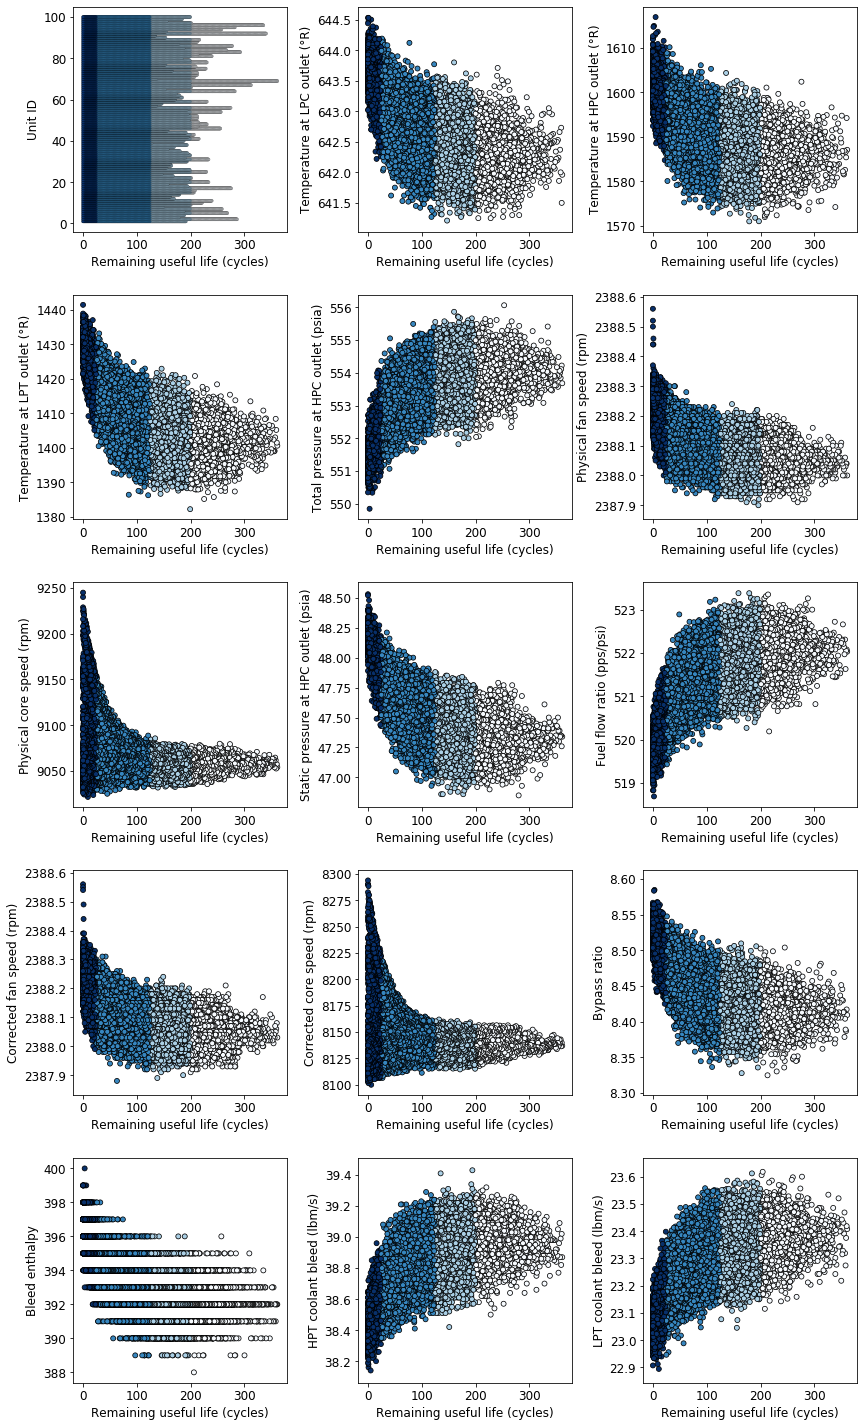

In [12]:
plt.subplots(5,3,figsize = (12.0,20.0),sharex = True)
j = 2
plt.subplot(5,3,1)
plt.scatter(df.ttf,df.unit,c = df.status,cmap = plt.cm.Blues,s = 10,\
            edgecolor = 'black',linewidth = 0.25)
plt.xlabel(r'Remaining useful life (cycles)')
plt.ylabel(r'Unit ID')
for i in sensors:
  plt.subplot(5,3,j)
  plt.scatter(df.ttf,df[i],c = df.status,cmap = plt.cm.Blues,s = 25,\
              edgecolor = 'black',linewidth = 0.75)
  plt.xlabel(r'Remaining useful life (cycles)')
  plt.ylabel(labels[j - 2])
  j += 1

plt.tight_layout()
plt.show()

In [0]:
dfnorm = normalization(df)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










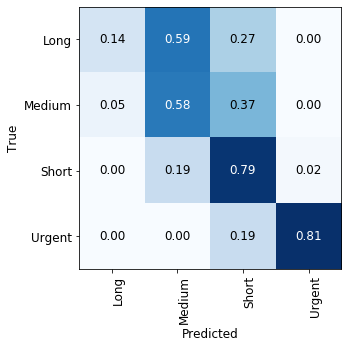

In [14]:
model = Sequential()

model.add(Dense(300,activation = 'relu',input_dim = 14))
model.add(Dense(100,activation = 'relu'))
model.add(Dense(300,activation = 'relu'))
model.add(Dense(4,activation = 'softmax'))

model.compile(optimizer = 'rmsprop',loss = 'binary_crossentropy',\
              metrics = ['accuracy'])

label = to_categorical(dfnorm.loc[:,'status'],num_classes = 4)

xtrain,xtest,ytrain,ytest = train_test_split(dfnorm.loc[:,sensors],\
                                             label,\
                                             test_size = 0.25,\
                                             random_state = 21)

model.fit(xtrain,ytrain,epochs = 10,batch_size = 32,verbose = 0)

plotConfusionMatrix(np.where(ytest != 0)[1],model.predict_classes(xtest),\
                    ['Long','Medium','Short','Urgent'],
                    title = 'Confusion Matrix',cmap = plt.cm.Blues)

plt.savefig('fig-5.ps',dpi = 300,format = 'ps')
plt.show()

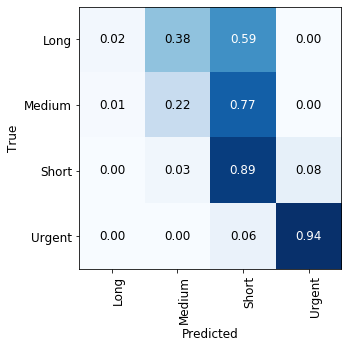

In [15]:
class_weight = {0:5.0,1:10.0,2:30.0,3:75.0}

model.fit(xtrain,ytrain,epochs = 10,batch_size = 32,verbose = 0,\
          class_weight = class_weight)

plotConfusionMatrix(np.where(ytest != 0)[1],model.predict_classes(xtest),\
                    ['Long','Medium','Short','Urgent'],
                    title = 'Confusion Matrix',cmap = plt.cm.Blues)

plt.savefig('fig-6.ps',dpi = 300,format = 'ps')
plt.show()